## Motivation

Generative Adversarial Networks were <a href = "https://arxiv.org/abs/1406.2661">first proposed by Ian J. Goodfellow and colleagues. </a> Since then, there has been further study and applications on its uses such as image editting.  

## Intuition

I like to think of it as a game between two players trying to best each other until they become equal. 

## Scenario

<a href ="https://www.kaggle.com/competitions/generative-dog-images/data">From Kaggle Competition, create a generative model that creates dog images from existing. </a>



## Strategy

My implementation will rely heavily on <a href = "https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html#inputs"> pytorch framework and tutorial</a>. I will be using the <a href = "https://arxiv.org/pdf/1511.06434.pdf">Deep Convolutional Generative Adversarial Network (DCGAN) proposed by Radford, Metz and Chintala. </a>. It will include the paper's hyperparameter implementation. 

## Notebook

github found here. 

In [12]:
# Import Libraries:

import numpy as np
import os
import random

import torch
import torch.nn as nn

import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


In [5]:
## Set-up

# Set random seed for reproducibility

random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [6]:
! nvidia-smi

Tue May 30 18:38:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.05    Driver Version: 525.85.05    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10G         On   | 00000000:00:18.0 Off |                    0 |
|  0%   36C    P0    63W / 300W |  10844MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# unzip images from .zip file
#!unzip ./data/all-dogs.zip -d ./data

## Prepare Dataset and Loader

In [8]:
image_size = 64 # as detailed in the paper
batch_size = 128

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 2

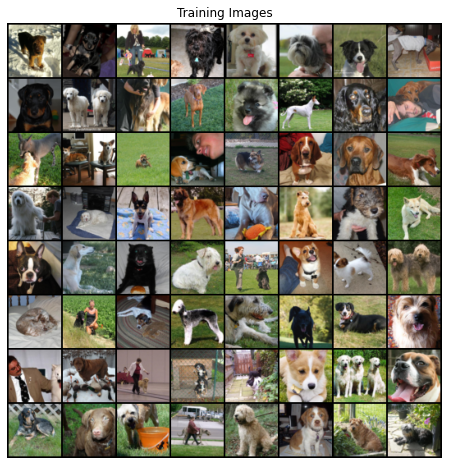

In [9]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = datasets.ImageFolder(root="./data/",
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # 3 channels at H x W
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers= 2)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### GAN Architecture

In [13]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [33]:
class Generator(nn.Module):
    def __init__(self, ngpu, noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
           # Input: N x channels_noise x 1 x 1
            self._block(noise, features_g * 8, 4, 1, 0),  # img: 4x4
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 8x8
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 16x16
            self._block(features_g * 2, features_g, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )
        
    
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, input):
        return self.main(input)

In [34]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

### Build the GAN

In [37]:
nz = 100 # size of latent vector

image_size = 64
ngf = 64 # number of features for generator
ndf = 64 # number of features of discriminator
nc = 3 

num_epochs = 50

netG = Generator(ngpu, nz, nc, ngf).to(device)
netD = Discriminator(nc, ndf).to(device)

netG.apply(weights_init)
netD.apply(weights_init)

fixed_noise = torch.randn(64, nz, 1, 1, device=device) # shape of tensor (64,100,1,1)


### Train the Neural Network

In [38]:

lr = 2e-4 # lr recommended by Paper
beta1 = 0.5

num_epochs = 50


# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [39]:
#Lists to keep track of progress
    
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device) # 128,100,1,1
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/50][0/161]	Loss_D: 1.3556	Loss_G: 8.0439	D(x): 0.5891	D(G(z)): 0.4771 / 0.0004
[0/50][50/161]	Loss_D: 0.0684	Loss_G: 8.4409	D(x): 0.9721	D(G(z)): 0.0335 / 0.0004
[0/50][100/161]	Loss_D: 0.2264	Loss_G: 8.3179	D(x): 0.9424	D(G(z)): 0.1357 / 0.0004
[0/50][150/161]	Loss_D: 0.2377	Loss_G: 6.8726	D(x): 0.9280	D(G(z)): 0.0892 / 0.0050
[1/50][0/161]	Loss_D: 0.2953	Loss_G: 6.8177	D(x): 0.8099	D(G(z)): 0.0356 / 0.0022
[1/50][50/161]	Loss_D: 0.2797	Loss_G: 3.1254	D(x): 0.8399	D(G(z)): 0.0405 / 0.0864
[1/50][100/161]	Loss_D: 0.4164	Loss_G: 3.0002	D(x): 0.7861	D(G(z)): 0.1198 / 0.0723
[1/50][150/161]	Loss_D: 0.4938	Loss_G: 5.2388	D(x): 0.9741	D(G(z)): 0.3024 / 0.0102
[2/50][0/161]	Loss_D: 0.4510	Loss_G: 4.0259	D(x): 0.9250	D(G(z)): 0.2763 / 0.0255
[2/50][50/161]	Loss_D: 0.1924	Loss_G: 4.8481	D(x): 0.8969	D(G(z)): 0.0517 / 0.0134
[2/50][100/161]	Loss_D: 0.5513	Loss_G: 5.1975	D(x): 0.8277	D(G(z)): 0.2477 / 0.0089
[2/50][150/161]	Loss_D: 0.0981	Loss_G: 5.4659	D(x): 0.9481	

[24/50][100/161]	Loss_D: 0.5385	Loss_G: 3.8240	D(x): 0.8647	D(G(z)): 0.2907 / 0.0302
[24/50][150/161]	Loss_D: 1.3116	Loss_G: 0.8199	D(x): 0.3460	D(G(z)): 0.0432 / 0.4933
[25/50][0/161]	Loss_D: 0.5368	Loss_G: 2.7559	D(x): 0.7944	D(G(z)): 0.2201 / 0.0845
[25/50][50/161]	Loss_D: 0.5024	Loss_G: 2.4121	D(x): 0.6863	D(G(z)): 0.0734 / 0.1187
[25/50][100/161]	Loss_D: 0.6974	Loss_G: 5.7759	D(x): 0.9680	D(G(z)): 0.4337 / 0.0049
[25/50][150/161]	Loss_D: 0.5462	Loss_G: 3.4362	D(x): 0.8785	D(G(z)): 0.2987 / 0.0427
[26/50][0/161]	Loss_D: 0.5388	Loss_G: 3.1361	D(x): 0.8348	D(G(z)): 0.2634 / 0.0594
[26/50][50/161]	Loss_D: 2.3027	Loss_G: 6.4262	D(x): 0.9585	D(G(z)): 0.8569 / 0.0028
[26/50][100/161]	Loss_D: 1.0649	Loss_G: 0.6135	D(x): 0.4453	D(G(z)): 0.0668 / 0.5881
[26/50][150/161]	Loss_D: 0.5166	Loss_G: 2.9228	D(x): 0.8560	D(G(z)): 0.2716 / 0.0694
[27/50][0/161]	Loss_D: 0.6102	Loss_G: 1.6491	D(x): 0.6671	D(G(z)): 0.1329 / 0.2429
[27/50][50/161]	Loss_D: 0.7532	Loss_G: 3.5048	D(x): 0.7891	D(G(z)): 0.357

[49/50][0/161]	Loss_D: 1.9158	Loss_G: 0.6197	D(x): 0.2089	D(G(z)): 0.0143 / 0.6046
[49/50][50/161]	Loss_D: 0.4606	Loss_G: 2.6509	D(x): 0.7844	D(G(z)): 0.1596 / 0.0967
[49/50][100/161]	Loss_D: 0.4308	Loss_G: 3.3390	D(x): 0.8853	D(G(z)): 0.2287 / 0.0519
[49/50][150/161]	Loss_D: 0.5439	Loss_G: 1.8326	D(x): 0.6617	D(G(z)): 0.0623 / 0.2087


### Evaluation

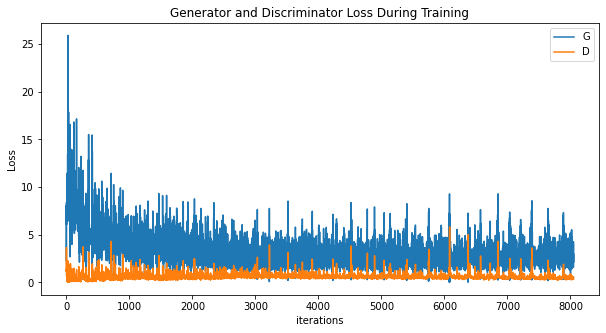

In [40]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

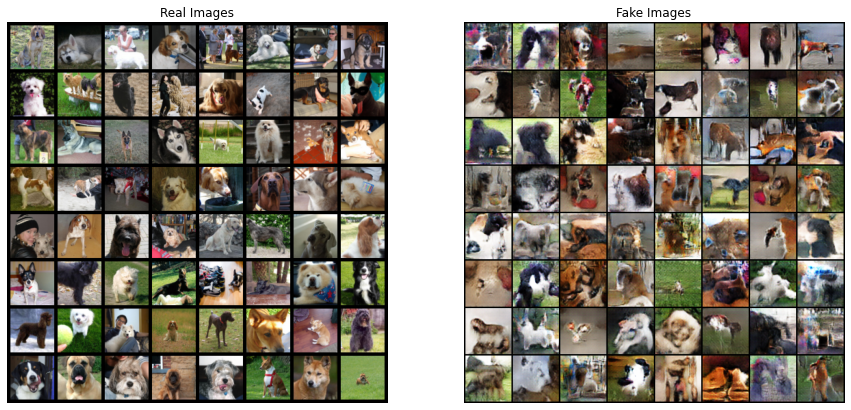

In [41]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

## Summary:

## Looking Ahead:

## Research/References:

1. Papers:
    - https://arxiv.org/pdf/1511.06434.pdf
    - https://proceedings.neurips.cc/paper_files/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf
2. Documentations:
    - https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html#generative-adversarial-networks
    - https://github.com/soumith/ganhacks
3. Samples:
    - https://www.youtube.com/watch?v=IZtv9s_Wx9I
        - intuition and code implementation by Aladdin Persson
    - annotated DCGAN Tutorial: https://github.com/godot107/sandbox/blob/main/dcgan_faces_tutorial-annotated.ipynb
4. Articles:
    - https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11
    - https://cs231n.github.io/convolutional-networks/#convert
        - for CNN architecture
5. Source Data:
    - https://www.kaggle.com/competitions/generative-dog-images/data
